### aim: 

### date: 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [5]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### baseline wind maps, 1955-1960 - get ukesm and tom

In [15]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]

scen = '1A'
mon = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_1A_monthly_wspd.nc'
tom_wind = xr.open_dataset(mon)


In [7]:

def make_yearlist(yrst, yrend, rname = 'bc370', ftype = 'diad-T-aux'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/data/greenocean/software/resources/MEDUSA/PROC2/medusa_{rname}_1y_{yrs[i]}*{ftype}*.nc'

        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist
                  
tylist = make_yearlist(1955, 1960)
ukesm_aux = xr.open_mfdataset(tylist)
tylist = make_yearlist(1955, 1960, ftype = 'MLD')
ukesm_mld = xr.open_mfdataset(tylist)

def make_yearlist_tom(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'\
        
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

tom_diadT = xr.open_mfdataset(make_yearlist_tom(1955,1960,'diad_T','TOM12_TJ_1ASA'))
tom_gridT = xr.open_mfdataset(make_yearlist_tom(1955,1960,'grid_T','TOM12_TJ_1ASA'))
tylist = make_yearlist(1955, 1960)
ukesm_aux = xr.open_mfdataset(tylist)
tylist = make_yearlist(1955, 1960, ftype = 'MLD')
ukesm_mld = xr.open_mfdataset(tylist)

In [17]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, northex = -50, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, northex], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    # lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))
    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = 10)
        cb.set_ticks(tticks, fontsize = 105)
        cb.ax.tick_params(labelsize=10)
    return cb

In [25]:
def plot_lats_wind(tomvar, ukesmvar, xmi, xma, stit = '', fname = '-'):

    fact = 0.5
    fig, axs = plt.subplots(2,6, figsize=(24*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    ###tom
    for i in range(1,13):
        #
        tv = tomvar.sel(y= slice(0,49)).sel(yr = slice(1955,1960)).sel(mon = 15).mean(dim = 'yr')
        axs[i-1].plot(tv.weighted(tmesh.csize.sel(y=slice(0,50))).mean(dim = 'x'),
         tmesh.nav_lat.sel(y=(slice(0,50))).sel(x=80), linewidth = 2, color = 'grey', alpha = 0.5, label = 'TOM \n yr. mean')
        tv = tomvar.sel(y= slice(0,49)).sel(yr = slice(1955,1960)).sel(mon = i).mean(dim = 'yr')
        axs[i-1].plot(tv.weighted(tmesh.csize.sel(y=slice(0,50))).mean(dim = 'x'),
         tmesh.nav_lat.sel(y=(slice(0,50))).sel(x=80), linewidth = 2, color = 'k', alpha = 1, label = 'TOM \n month. mean')
        axs[i-1].set_title(f'month {i}')

    ##UKESM
    for i in range(1,13):
        tv = ukesmvar.groupby('time_counter.year').mean().sel(y=slice(0,140)).mean(dim = 'year')
        axs[i-1].plot(tv.weighted(ukmesh.area.sel(y=slice(0,140))).mean(dim = 'x'), \
                ukmesh.nav_lat.sel(y=(slice(0,140))).sel(x=80), linewidth = 2, color = 'r', alpha = 0.3, label = 'UKESM \n yr. mean')
        tv = ukesmvar.groupby('time_counter.month').mean().sel(y=slice(0,140)).sel(month = i)
        axs[i-1].plot(tv.weighted(ukmesh.area.sel(y=slice(0,140))).mean(dim = 'x'), \
                ukmesh.nav_lat.sel(y=(slice(0,140))).sel(x=80), linewidth = 2, color = 'r', alpha = 1, label = 'UKESM \n month. mean')

    for i in range(0,12):
        axs[i].set_xlim([xmi, xma])
        axs[i].set_ylim([-80,-30])
        axs[i].set_yticks(np.arange(-80,-20,10))
        axs[i].grid(alpha = 0.3)
        axs[5].legend(bbox_to_anchor = [1,1], fontsize = 9)
        axs[0].set_ylabel('latitude')


    plt.suptitle(stit)
    plt.tight_layout()
    fig.savefig(f'./FIGS/{fname}')

In [26]:

def plot_lats(tomvar, ukvar, vmin, vmax, suptit = '', fname = '-', fact2 = 1):

    fact = 0.5
    fig, axs = plt.subplots(2,6, figsize=(24*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    ###tom

    for i in range(1,13):
        
        tv = tomvar.groupby('time_counter.year').mean().sel(y=slice(0,50)).mean(dim = 'year')* fact2
        axs[i-1].plot(tv.weighted(tmesh.csize.sel(y=slice(0,50))).mean(dim = 'x'),
         tmesh.nav_lat.sel(y=(slice(0,50))).sel(x=80), linewidth = 2, color = 'grey', alpha = 0.5, label = 'TOM \n yr. mean')
        tv = tomvar.groupby('time_counter.month').mean().sel(y=slice(0,50)).sel(month = i) * fact2
        axs[i-1].plot(tv.weighted(tmesh.csize.sel(y=slice(0,50))).mean(dim = 'x'),
         tmesh.nav_lat.sel(y=(slice(0,50))).sel(x=80), linewidth = 2, color = 'k', alpha = 1, label = 'TOM \n monthly mean')
        axs[i-1].set_title(f'm. {i}')

    ##UKESM

    for i in range(1,13):
        tv = ukvar.groupby('time_counter.year').mean().sel(y=slice(0,140)).mean(dim = 'year')
        axs[i-1].plot(tv.weighted(ukmesh.area.sel(y=slice(0,140))).mean(dim = 'x'), \
                ukmesh.nav_lat.sel(y=(slice(0,140))).sel(x=80), linewidth = 2, color = 'r', alpha = 0.3, label = 'UKESM \n yr. mean')
        tv = ukvar.groupby('time_counter.month').mean().sel(y=slice(0,140)).sel(month = i)
        axs[i-1].plot(tv.weighted(ukmesh.area.sel(y=slice(0,140))).mean(dim = 'x'), \
                ukmesh.nav_lat.sel(y=(slice(0,140))).sel(x=80), linewidth = 2, color = 'r', alpha = 1, label = 'UKESM \n monthly. mean')

    for i in range(0,12):
        axs[i].set_xlim([xmi, xma])
        axs[i].set_ylim([-80,-30])
        axs[i].set_yticks(np.arange(-80,-20,10))
        axs[i].grid(alpha = 0.3)
        axs[5].legend(bbox_to_anchor = [1,1], fontsize = 9)
        axs[0].set_ylabel('latitude')
        axs[i].axvline(x=0)

    plt.suptitle(stit)
    plt.tight_layout()
    fig.savefig(f'./FIGS/{fname}')

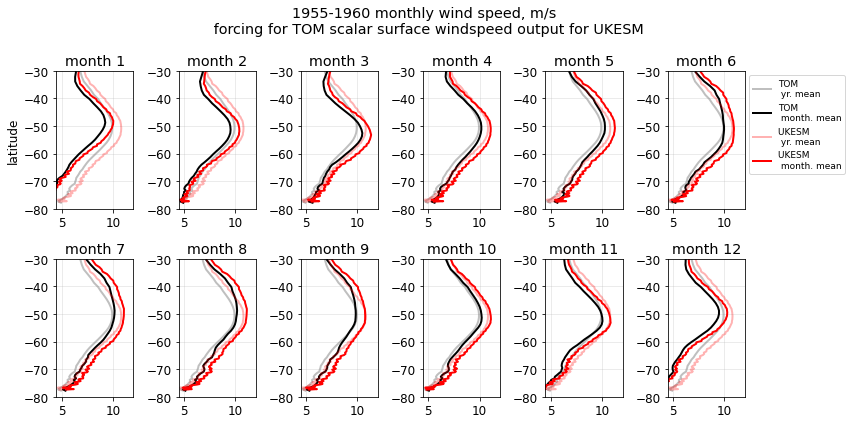

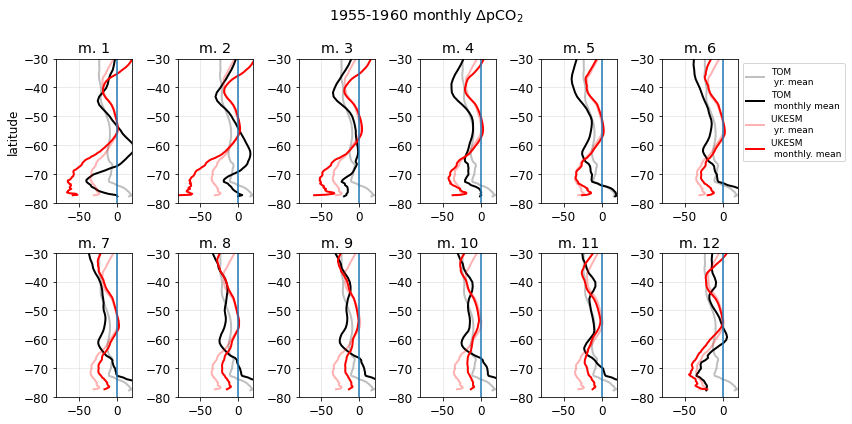

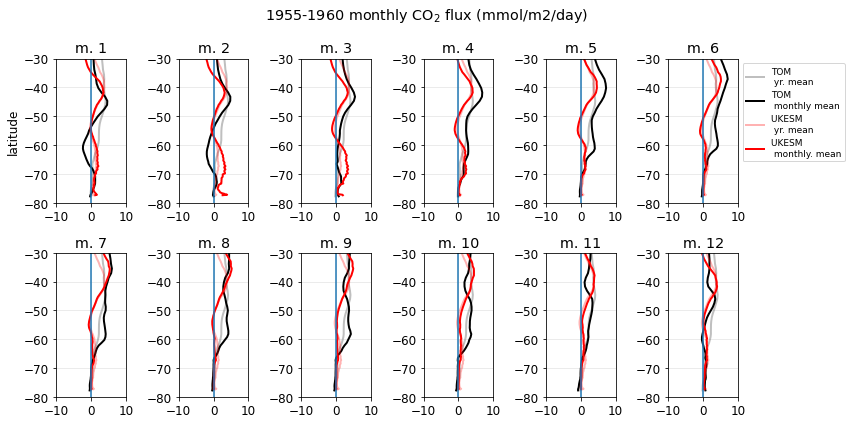

In [27]:
stit = '1955-1960 monthly wind speed, m/s \n forcing for TOM scalar surface windspeed output for UKESM'
xmi = 4.5; xma = 12
tomvar = tom_wind.mean_wspd
ukesmvar = ukesm_aux.WIND
plot_lats_wind(tomvar, ukesmvar, xmi, xma, stit = stit, fname = 'LATMONTH_wind.png')


stit = '1955-1960 monthly $\Delta$pCO$_2$'
fname = 'LATMONTH_dpco2.png'
ukvar = ukesm_aux.OCN_DPCO2
tomvar = tom_diadT.dpCO2
xmi = -80
xma = 20
plot_lats(tomvar, ukvar, xmi, xma, suptit = stit, fact2 = 1, fname = fname)

fact2 = 60*60*24*1000
stit = '1955-1960 monthly CO$_2$ flux (mmol/m2/day)'
fname = 'LATMONTH_co2flux.png'
ukvar = ukesm_aux.CO2FLUX
tomvar = tom_diadT.Cflx
xmi = -10
xma = 10
plot_lats(tomvar, ukvar, xmi, xma, suptit = stit, fact2 = fact2, fname = fname)

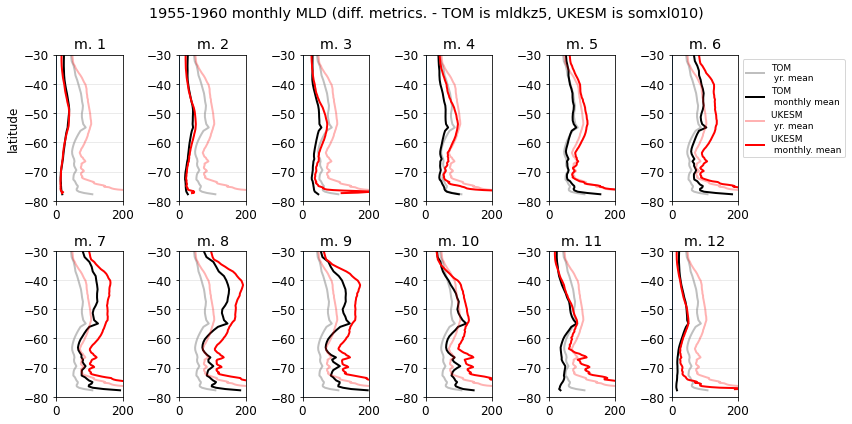

In [28]:
fact2 = 1
stit = '1955-1960 monthly MLD (diff. metrics. - TOM is mldkz5, UKESM is somxl010)'
fname = 'LATMONTH_MLD.png'
ukvar = ukesm_mld.somxl010
tomvar = tom_gridT.mldkz5
xmi = 0
xma = 200
plot_lats(tomvar, ukvar, xmi, xma, suptit = stit, fact2 = fact2, fname = fname)


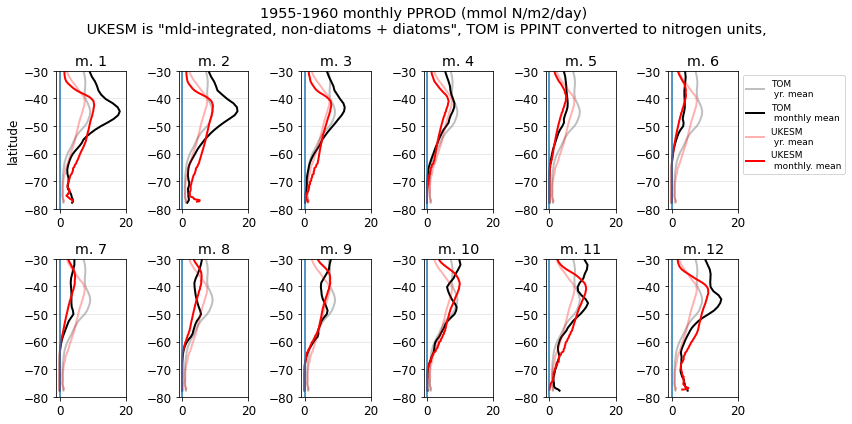

In [29]:
ML_PRT = ukesm_aux.ML_PRD + ukesm_aux.ML_PRN

#mmol-N/m2/d

fact2 = 16/106 *60*60*24 *1000 #mol/mmol * hrs/day *60sec/min *60min/hr *16N/106C (redfiedl)
stit = '1955-1960 monthly PPROD (mmol N/m2/day) \n UKESM is "mld-integrated, non-diatoms + diatoms", TOM is PPINT converted to nitrogen units, '
fname = 'LATMONTH_PPROD.png'
ukvar = ML_PRT
tomvar = tom_diadT.PPINT
xmi = -1
xma = 20
plot_lats(tomvar, ukvar, xmi, xma, suptit = stit, fact2 = fact2, fname = fname)


### why is the wind forcing different?

In [30]:
raw = xr.open_dataset('/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1955m01.nc')
raw_uflx = raw.uwind10m[:,0:144,:].values
raw_vflx = raw.vwind10m[:,0:144,:].values
raw_wspd = np.nanmean(np.sqrt(raw_uflx**2 + raw_vflx**2),axis = 0)



proc_taux = xr.open_dataset('/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/hist/u-bc370_hist//taux_1d_1955_daily.nc', decode_times=False)
tom_uflx = proc_taux.uflx.isel(time_counter = slice(0,31))
proc_tauy = xr.open_dataset('/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/hist/u-bc370_hist//tauy_1d_1955_daily.nc', decode_times=False)
tom_vflx = proc_tauy.vflx.isel(time_counter = slice(0,31))
tom_wspd = np.nanmean(np.sqrt(tom_uflx**2 + tom_vflx**2),axis = 0)

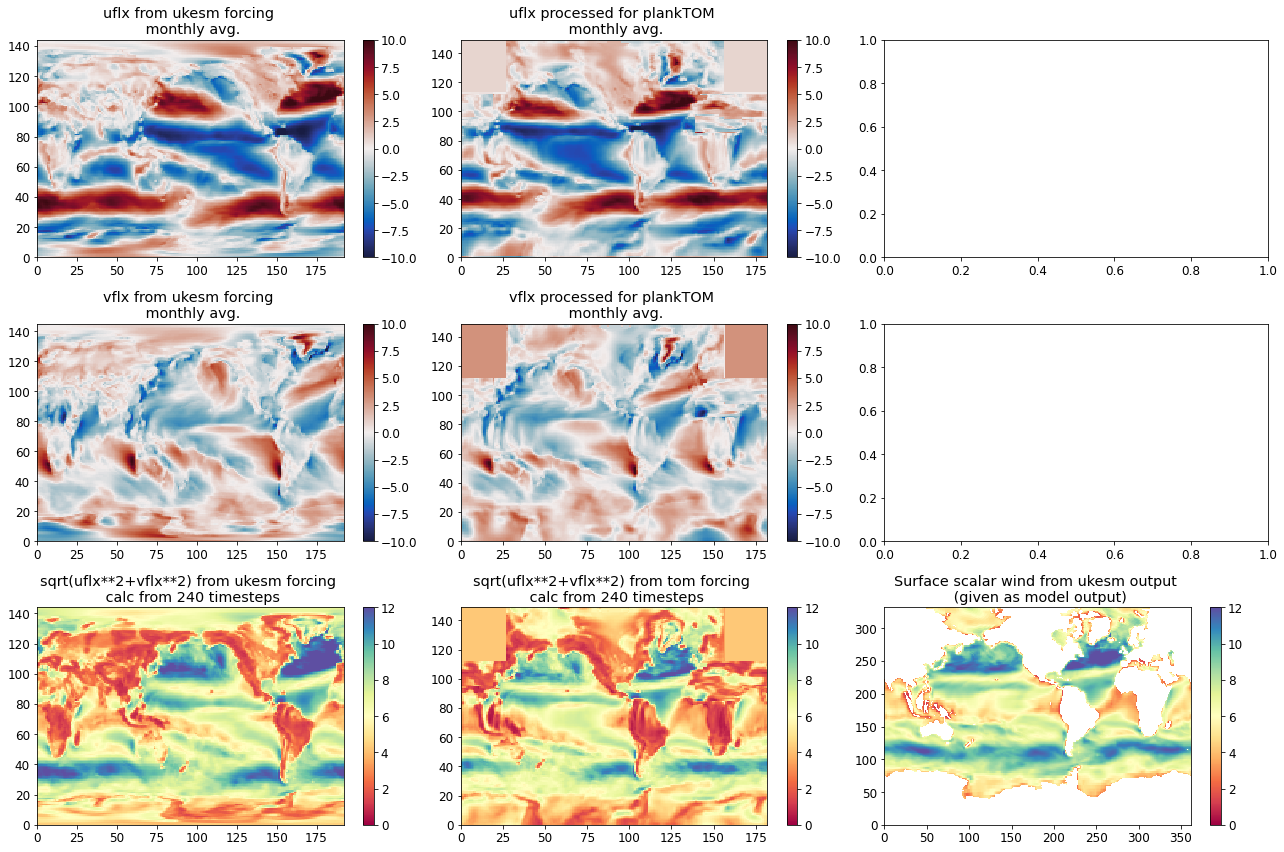

In [31]:
raw = xr.open_dataset('/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/bc370_wind_y1955m01.nc')
raw.uwind10m.mean(dim = 'time_counter')


proc_taux = xr.open_dataset('/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/hist/u-bc370_hist//taux_1d_1955_daily.nc', decode_times=False)
proc_taux.uflx.isel(time_counter = slice(0,31)).mean(dim = 'time_counter')
proc_tauy = xr.open_dataset('/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/hist/u-bc370_hist//tauy_1d_1955_daily.nc', decode_times=False)
proc_tauy.vflx.isel(time_counter = slice(0,31)).mean(dim = 'time_counter')

proc_tauy


tcm = cm.balance
tvmin = -10; tvmax = 10
fact = 1.5
fig, axs = plt.subplots(3,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
w = axs[0].pcolormesh(raw.uwind10m.mean(dim = 'time_counter'), cmap = tcm, vmin = tvmin, vmax = tvmax)
cb = fig.colorbar(w, ax = axs[0])
w = axs[1].pcolormesh(proc_taux.uflx.isel(time_counter = slice(0,31)).mean(dim = 'time_counter'), cmap = tcm, vmin = tvmin, vmax = tvmax)
cb = fig.colorbar(w, ax = axs[1])

w = axs[3].pcolormesh(raw.vwind10m.mean(dim = 'time_counter'), cmap = tcm, vmin = tvmin, vmax = tvmax)
cb = fig.colorbar(w, ax = axs[3])
w = axs[4].pcolormesh(proc_tauy.vflx.isel(time_counter = slice(0,31)).mean(dim = 'time_counter'), cmap = tcm, vmin = tvmin, vmax = tvmax)
cb = fig.colorbar(w, ax = axs[4])

tcm  = plt.cm.get_cmap('Spectral')
tvmin = 0; tvmax = 12
proc_wind = np.sqrt((proc_tauy.vflx.isel(time_counter = slice(0,31)).mean(dim = 'time_counter').values **2)+
(proc_taux.uflx.isel(time_counter = slice(0,31)).mean(dim = 'time_counter').values **2))

# print(raw.vwind10m)
# print(raw.uwind10m)
raw_wind = np.sqrt(raw.vwind10m.isel(latitude_1 = slice(0,144)).mean(dim = 'time_counter').values**2 + raw.uwind10m.mean(dim = 'time_counter').values**2)
w = axs[6].pcolormesh(raw_wspd, cmap = tcm, vmin = tvmin, vmax = tvmax)
cb = fig.colorbar(w, ax = axs[6])
w = axs[7].pcolormesh(tom_wspd, cmap = tcm, vmin = tvmin, vmax = tvmax)
cb = fig.colorbar(w, ax = axs[7])
w = axs[8].pcolormesh(ukesm_aux.WIND.isel(time_counter = 1),cmap = tcm, vmin = tvmin, vmax = tvmax)
cb = fig.colorbar(w, ax = axs[8])

axs[0].set_title('uflx from ukesm forcing \n monthly avg.')
axs[1].set_title('uflx processed for plankTOM \n monthly avg.')
axs[3].set_title('vflx from ukesm forcing \n monthly avg.')
axs[4].set_title('vflx processed for plankTOM \n monthly avg.')
axs[6].set_title('sqrt(uflx**2+vflx**2) from ukesm forcing \n calc from 240 timesteps')
axs[7].set_title('sqrt(uflx**2+vflx**2) from tom forcing \n calc from 240 timesteps')
axs[8].set_title('Surface scalar wind from ukesm output \n (given as model output)')

plt.tight_layout()
fig.savefig('./FIGS/uflx_vflx_calc.png')

In [32]:
scendict = {
    # Baynes Sound
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

### 

## maps

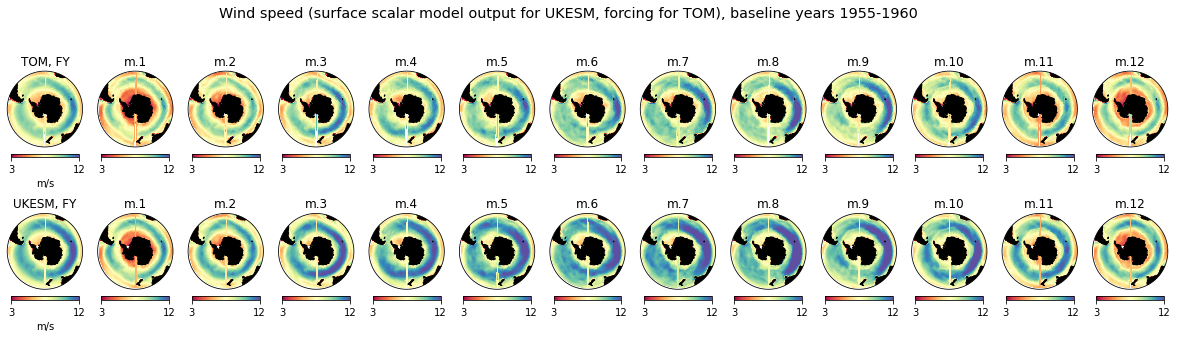

In [33]:

#for histograms
vmin = 2; vmax = 12
#for plots
tvmin = 3; tvmax = 12; tticks = [3, 12]
tcm  = plt.cm.get_cmap('Spectral')

lons = tmesh['nav_lon'][0:50,:].values
lats = tmesh['nav_lat'][0:50,:].values


fact = 0.4
tfig = plt.figure(figsize=[52*fact, 12*fact])

ax1 = tfig.add_subplot(2, 13, 1, projection=ccrs.Orthographic(0, -90))
tv = tom_wind.mean_wspd.sel(yr = slice(1955,1960)).sel(y= slice(0,49)).sel(mon = 15).mean(dim = 'yr')
plot_southern(tfig, ax1, lons, lats, tv, tvmin, 
          tvmax, tticks, northex = -25, fs = 12, 
          tit = f'TOM, FY', cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = True)
    
for i in range(1,13):
    ax1 = tfig.add_subplot(2, 13, i+1, projection=ccrs.Orthographic(0, -90))
    tv = tom_wind.mean_wspd.sel(yr = slice(1955,1960)).sel(y= slice(0,49)).sel(mon = i).mean(dim = 'yr')


    plot_southern(tfig, ax1, lons, lats, tv, tvmin, 
                  tvmax, tticks, northex = -25, fs = 12, 
                  tit = f'm.{i}', cbarlab = '', tcmap = tcm, lm = True, cbr = True)
    
    
### ukesm
ax1 = tfig.add_subplot(2, 13, 1+13, projection=ccrs.Orthographic(0, -90))

tv = ukesm_aux.WIND.groupby('time_counter.year').mean().sel(y=slice(0,140)).mean(dim = 'year')

lons = ukmesh['nav_lon'][0:140,:].values
lats = ukmesh['nav_lat'][0:140,:].values


plot_southern(tfig, ax1, lons, lats, tv, tvmin, 
          tvmax, tticks, northex = -25, fs = 12, 
          tit = f'UKESM, FY', cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = True)
    
for i in range(1,13):
    tv = ukesm_aux.WIND.groupby('time_counter.month').mean().sel(y=slice(0,140)).sel(month = i)

    ax1 = tfig.add_subplot(2, 13, i+14, projection=ccrs.Orthographic(0, -90))

    plot_southern(tfig, ax1, lons, lats, tv, tvmin, 
                  tvmax, tticks, northex = -25, fs = 12, 
                  tit = f'm.{i}', cbarlab = '', tcmap = tcm, lm = True, cbr = True)
    
plt.suptitle('Wind speed (surface scalar model output for UKESM, forcing for TOM), baseline years 1955-1960')
plt.tight_layout()
tfig.savefig(f'./FIGS/BASEMAPS_wind.png')

In [13]:
def plot_var(tomvar, ukvar, suptit, tvmin, tvmax, tticks, fact2 = 1, tcm = cm.balance, cbarlab = '', fname = ''):

    lons = tmesh['nav_lon'][0:50,:].values
    lats = tmesh['nav_lat'][0:50,:].values
    fact = 0.4
    tfig = plt.figure(figsize=[52*fact, 12*fact])

    ax1 = tfig.add_subplot(2, 13, 1, projection=ccrs.Orthographic(0, -90))
    tv = tomvar.groupby('time_counter.year').mean().sel(y=slice(0,50)).mean(dim = 'year')*fact2
    plot_southern(tfig, ax1, lons, lats, tv, tvmin, 
              tvmax, tticks, northex = -25, fs = 12, 
              tit = f'TOM, FY', cbarlab = cbarlab, tcmap = tcm, lm = True, cbr = True)

    for i in range(1,13):
        ax1 = tfig.add_subplot(2, 13, i+1, projection=ccrs.Orthographic(0, -90))
        tv = tomvar.groupby('time_counter.month').mean().sel(y=slice(0,50)).sel(month = i)*fact2


        plot_southern(tfig, ax1, lons, lats, tv, tvmin, 
                      tvmax, tticks, northex = -25, fs = 12, 
                      tit = f'm.{i}', cbarlab = '', tcmap = tcm, lm = True, cbr = True)

    ax1 = tfig.add_subplot(2, 13, 1+13, projection=ccrs.Orthographic(0, -90))

    tv = ukvar.groupby('time_counter.year').mean().sel(y=slice(0,140)).mean(dim = 'year')

    lons = ukmesh['nav_lon'][0:140,:].values
    lats = ukmesh['nav_lat'][0:140,:].values

    plot_southern(tfig, ax1, lons, lats, tv, tvmin, 
              tvmax, tticks, northex = -25, fs = 12, 
              tit = f'UKESM, FY', cbarlab = cbarlab, tcmap = tcm, lm = True, cbr = True)

    for i in range(1,13):
        tv = ukvar.groupby('time_counter.month').mean().sel(y=slice(0,140)).sel(month = i)

        ax1 = tfig.add_subplot(2, 13, i+14, projection=ccrs.Orthographic(0, -90))

        plot_southern(tfig, ax1, lons, lats, tv, tvmin, 
                      tvmax, tticks, northex = -25, fs = 12, 
                      tit = f'm.{i}', cbarlab = '', tcmap = tcm, lm = True, cbr = True)

    
    plt.suptitle(suptit)
    plt.tight_layout()
    tfig.savefig(f'./FIGS/{fname}')


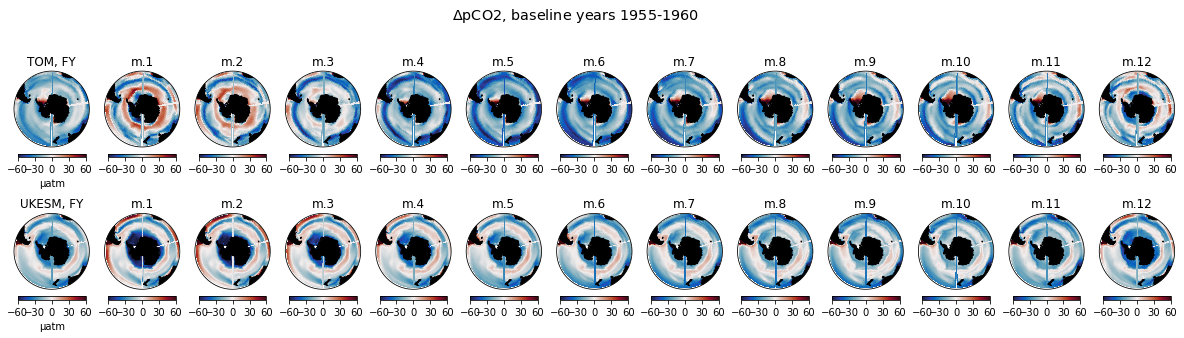

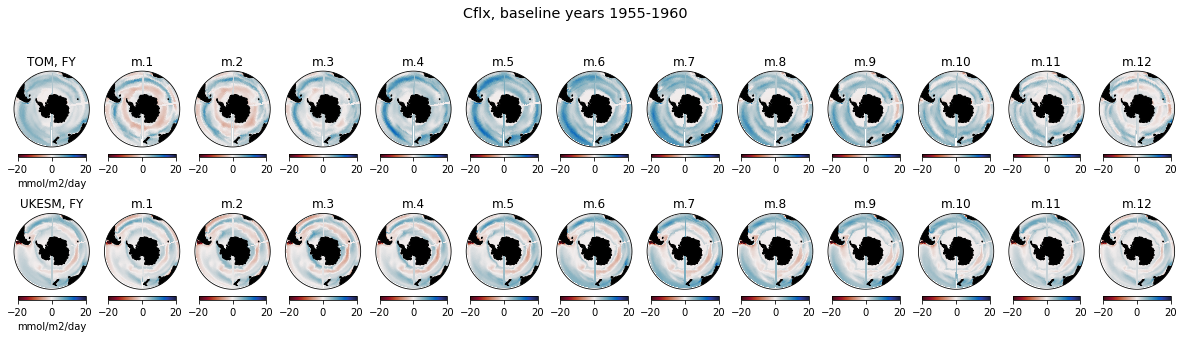

In [35]:
tvmin = -60; tvmax = 60; tticks = [-60, -30, 0, 30, 60]
suptit = '$\Delta$pCO2, baseline years 1955-1960'
tcm = cm.balance
tomvar = tom_diadT.dpCO2
ukvar = ukesm_aux.OCN_DPCO2
cbarlab = 'µatm'

plot_var(tomvar, ukvar, suptit, tvmin, tvmax, tticks, cbarlab = cbarlab, fname = 'BASEMAPS_dpco2.png')


tvmin = -20; tvmax = 20; tticks = [-20, 0, 20]
suptit = 'Cflx, baseline years 1955-1960'
tcm = cm.balance_r
tomvar = tom_diadT.Cflx
ukvar = ukesm_aux.CO2FLUX
fact2 = 60*60*24*1000
cbarlab = 'mmol/m2/day'

plot_var(tomvar, ukvar, suptit, tvmin, tvmax, tticks, cbarlab = cbarlab, fact2 = fact2, tcm = tcm, fname = 'BASEMAPS_co2flux.png')

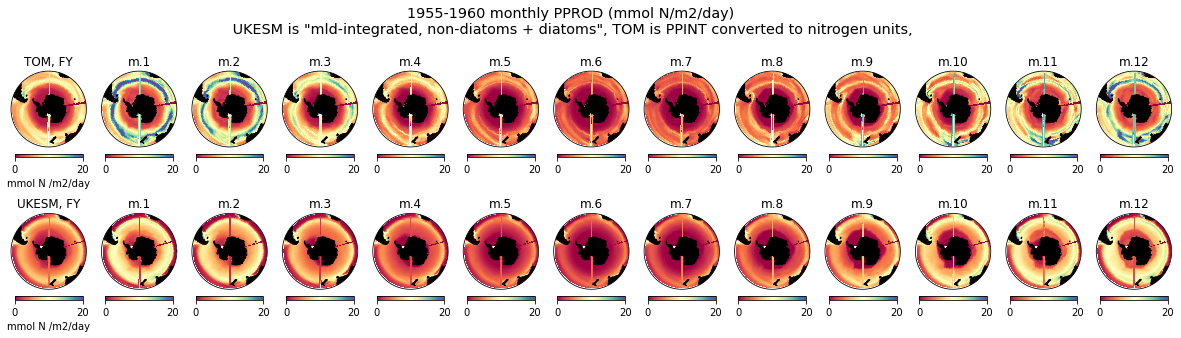

In [36]:
tvmin = 0; tvmax = 20; tticks = [0, 20]
fact2 = 16/106 *60*60*24 *1000 #mol/mmol * hrs/day *60sec/min *60min/hr *16N/106C (redfiedl)
suptit = '1955-1960 monthly PPROD (mmol N/m2/day) \n UKESM is "mld-integrated, non-diatoms + diatoms", TOM is PPINT converted to nitrogen units, '

ukvar = ML_PRT
tomvar = tom_diadT.PPINT
tcm   = plt.cm.get_cmap('Spectral')
cbarlab = 'mmol N /m2/day'

plot_var(tomvar, ukvar, suptit, tvmin, tvmax, tticks, tcm = tcm, cbarlab = cbarlab, fact2 = fact2, fname = 'BASEMAPS_PPROD.png')

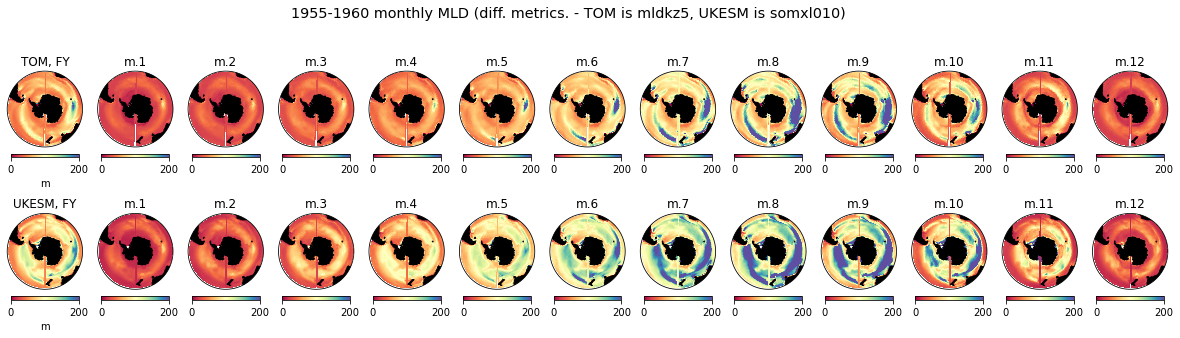

In [37]:
tvmin = 0; tvmax = 200; tticks = [0, 200]
stit = '1955-1960 monthly MLD (diff. metrics. - TOM is mldkz5, UKESM is somxl010)'
tcm   = plt.cm.get_cmap('Spectral')
cbarlab = 'm'

ukvar = ukesm_mld.somxl010
tomvar = tom_gridT.mldkz5


plot_var(tomvar, ukvar, stit, tvmin, tvmax, tticks, tcm = tcm, cbarlab = cbarlab, fact2 = 1, fname = 'BASEMAPS_MLD.png')

### clhlorophyll

In [9]:
tom_diadT = xr.open_mfdataset(make_yearlist_tom(1955,1960,'diad_T','TOM12_TJ_1ASA'))
tylist = make_yearlist(1955, 1960, rname = 'bc370', ftype = 'CHLTADIC')
tomchl = tom_diadT.TChl.isel(deptht = 0)
ukesm_chlds = xr.open_mfdataset(tylist)

In [10]:
ukesm_chlds['CHL'] = ukesm_chlds.CHD + ukesm_chlds.CHN
tom_chl = tom_diadT.TChl

In [ ]:
ukesm_chlds.CHD

In [11]:
ukchl = ukesm_chlds['CHL'].isel(deptht = 0)
tomchl = tom_diadT.TChl.isel(deptht = 0)

print(np.nanmean(tomchl))

2.444717e-07


In [61]:
tom_diadT.TChl

<xarray.DataArray 'TChl' (time_counter: 72, deptht: 31, y: 149, x: 182)>
dask.array<concatenate, shape=(72, 31, 149, 182), dtype=float32, chunksize=(12, 31, 149, 182), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
  * deptht         (deptht) float32 4.999938 15.000288 ... 4749.913 5250.2266
    time_centered  (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) object 1955-01-16 12:00:00 ... 1960-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    long_name:           total Chl
    units:               g Chl/L
    online_operation:    average
    interval_operation:  5760 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5760 s)

## 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


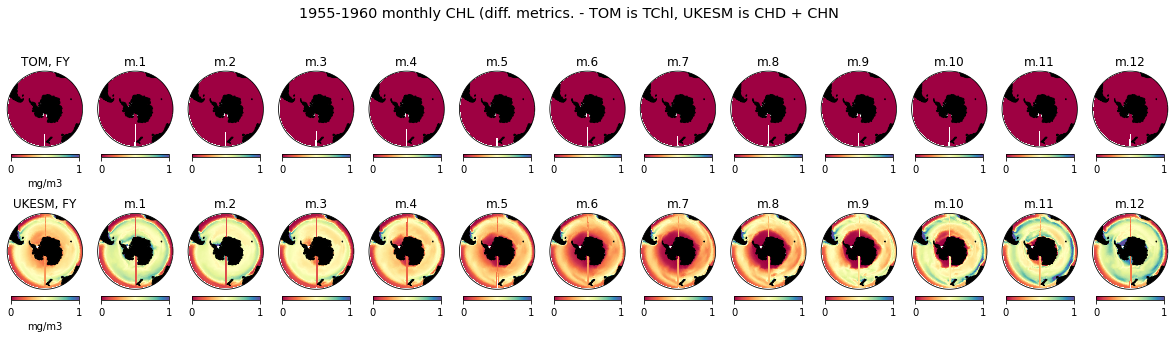

In [18]:
tvmin = 0; tvmax = 1; tticks = [0, 1]
stit = '1955-1960 monthly CHL (diff. metrics. - TOM is TChl, UKESM is CHD + CHN'
tcm   = plt.cm.get_cmap('Spectral')
cbarlab = 'mg/m3'

ukvar = ukchl
tomvar = tomchl


plot_var(tomvar, ukvar, stit, tvmin, tvmax, tticks, tcm = tcm, cbarlab = cbarlab, fact2 = 1000, fname = 'BASEMAPS_CHL.png')

In [28]:
avg_chl

<xarray.DataArray 'TChl' (y: 149, x: 182)>
dask.array<mul, shape=(149, 182), dtype=float32, chunksize=(149, 182), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    deptht   float32 4.999938
Dimensions without coordinates: y, x

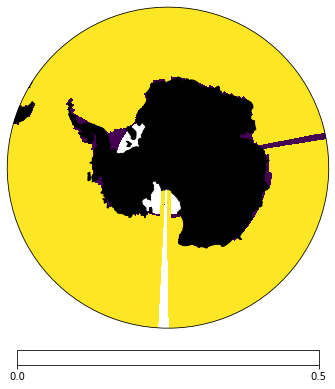

In [35]:
fact2 = 1000
avg_chl = tomchl.mean(dim = 'time_counter')*fact2
avg_chl



fact = 1.1
#fig, axs = plt.subplots(1, 1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
tfig = plt.figure(figsize=[12*fact, 6*fact])

ax1 = tfig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(0, -90))

lons = tmesh['nav_lon'][0:50,:].values
lats = tmesh['nav_lat'][0:50,:].values
    
plot_southern(fig, ax1, lons, lats, avg_chl.isel(y = slice(0,50)), 0,
                  1e-6, [0, 0.5], northex = -50, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True)

In [36]:
tom_diadT = xr.open_mfdataset(make_yearlist_tom(1955,1960,'diad_T','TOM12_TJ_1ASA'))
tylist = make_yearlist(1955, 1960, rname = 'bc370', ftype = 'CHLTADIC')
tomchl = tom_diadT.TChl.isel(deptht = 0)